$$ \eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right) $$


$$ \eta_t $$  is the learning rate 
$$ T_{\text{cur}} $$  is the number of epochs since the last restart 

In [20]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from operator import attrgetter,itemgetter
from functools import partial
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from torch.optim import Optimizer
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [5]:
import math

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/andres/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [8]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [9]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [10]:
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [11]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [12]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

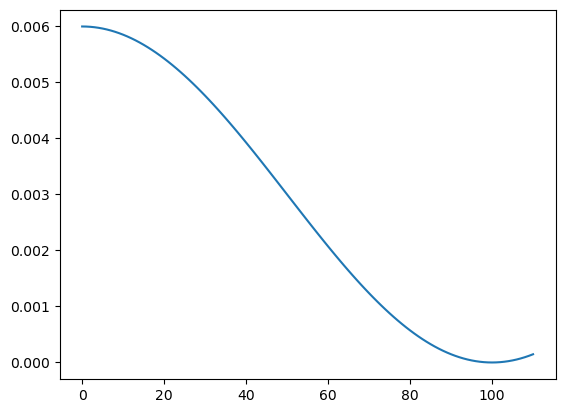

In [13]:
sched_lrs(sched,110)

For the COSINEANNEALINGLR we need parameters: `optimizer`,`Maximun iterations`,`last_epoch` cumplying with pytoch API

# first attempt

$$ \eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right) $$

In [14]:
def CosAni(opt,max_it,last_epoch):
    if not isinstance(opt,Optimizer):
        raise TypeError(f'wrong type {type(optimizer).__name__}')
    lr_max = opt.param_groups[0]['initial_lr']

In [15]:
class CosAni:
    def __init__(self,opt,max_it,last_epoch = -1):
        if not isinstance(opt,Optimizer):
            raise TypeError(f'wrong type {type(optimizer).__name__}')
        self.optimizer=opt
        self.eta_max = opt.param_groups[0]['lr']
        self.eta_min = 0
        self.T_cur=0
        self.T_max=max_it
        self.current_lr = opt.param_groups[0]['lr']
    ## you need to run this function after optimizer step
    def step(self):
        self.current_lr= self.eta_min + 1/2*(self.eta_max-self.eta_min)*(1+math.cos(self.T_cur/self.T_max * math.pi))
        #print(f'new_lr = {self.current_lr}')
        self.T_cur+=1
        ##self.optimizer.param_groups[0]['lr'] = self.current_lr
    def get_last_lr(self):
        return  self.current_lr
        
        

In [16]:
sched2 = CosAni(opt,100)

new_lr = 0.00014683045111453906
new_lr = 0.00014679422513249035
new_lr = 0.00014668558293701487
new_lr = 0.00014650463174484303
new_lr = 0.00014625155013295503
new_lr = 0.00014592658786234683
new_lr = 0.0001455300656315464
new_lr = 0.00014506237476012278
new_lr = 0.00014452397680250113
new_lr = 0.000143915403092464
new_lr = 0.00014323725421878922
new_lr = 0.0001424901994325412
new_lr = 0.00014167497598660094
new_lr = 0.00014079238840808647
new_lr = 0.0001398433077043817
new_lr = 0.0001388286705035573
new_lr = 0.0001377494781300318
new_lr = 0.00013660679561638544
new_lr = 0.00013540175065230144
new_lr = 0.0001341355324716725
new_lr = 0.00013280939067897055
new_lr = 0.00013142463401603793
new_lr = 0.00012998262907051728
new_lr = 0.00012848479892719445
new_lr = 0.00012693262176358564
new_lr = 0.00012532762939115476
new_lr = 0.0001236714057436003
new_lr = 0.00012196558531370408
new_lr = 0.00012021185154028425
new_lr = 0.00011841193514684431
new_lr = 0.00011656761243355802
new_lr = 0.000114

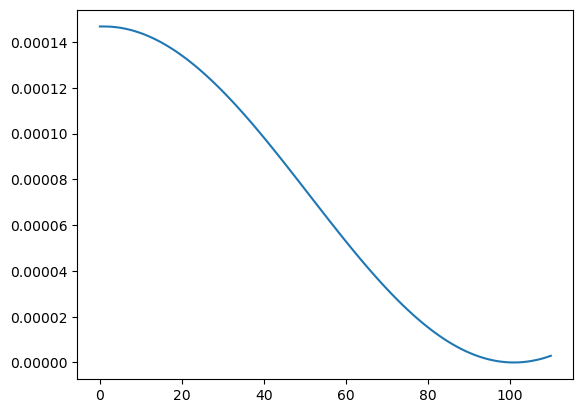

In [17]:
sched_lrs(sched2,110)

## try with putorch

In [22]:
def _lr(cb): return cb.pg['lr']

In [18]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.796,0.553,0,train
0.854,0.399,0,eval
0.875,0.345,1,train
0.866,0.359,1,eval
0.890,0.301,2,train
0.874,0.341,2,eval


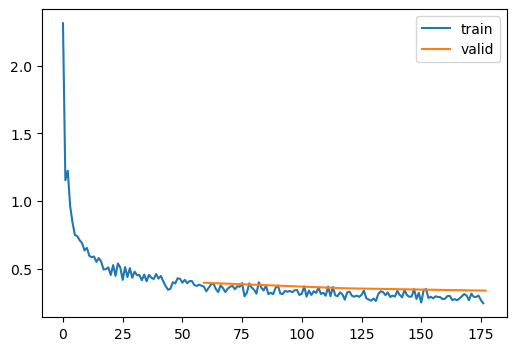

In [23]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

In [26]:
sched = partial(CosAni, max_it=tmax)

accuracy,loss,epoch,train
0.796,0.552,0,train
0.847,0.419,0,eval
0.872,0.349,1,train
0.864,0.360,1,eval
0.886,0.307,2,train
0.876,0.342,2,eval


new_lr = 0.02
new_lr = 0.01999842488663838
new_lr = 0.019993700042749935
new_lr = 0.019985826956767618
new_lr = 0.019974808108892014
new_lr = 0.019960646970310025
new_lr = 0.01994334800210137
new_lr = 0.019922916653833247
new_lr = 0.019899359361843578
new_lr = 0.019872683547213447
new_lr = 0.01984289761342926
new_lr = 0.019810010943735478
new_lr = 0.019774033898178667
new_lr = 0.019734977810343866
new_lr = 0.019692854983784234
new_lr = 0.01964767868814516
new_lr = 0.01959946315498402
new_lr = 0.01954822357328692
new_lr = 0.01949397608468381
new_lr = 0.019436737778363525
new_lr = 0.01937652668569028
new_lr = 0.019313361774523388
new_lr = 0.019247262943241958
new_lr = 0.019178251014476465
new_lr = 0.019106347728549133
new_lr = 0.01903157573662524
new_lr = 0.018953958593577493
new_lr = 0.018873520750565715
new_lr = 0.018790287547334174
new_lr = 0.01870428520422897
new_lr = 0.018615540813938063
new_lr = 0.018524082332956427
new_lr = 0.018429938572779154
new_lr = 0.01833313919082515
new_lr 

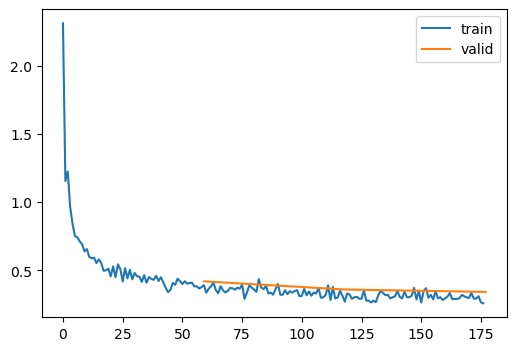

new_lr = 0.015
new_lr = 0.014845508703326502
new_lr = 0.014689490961552512
new_lr = 0.014531995923803973
new_lr = 0.014373073204588556
new_lr = 0.014212772868165958
new_lr = 0.014051145412776536
new_lr = 0.013888241754733209
new_lr = 0.013724113212381659
new_lr = 0.013558811489933908
new_lr = 0.013392388661180301
new_lr = 0.013224897153085089
new_lr = 0.013056389729270739
new_lr = 0.01288691947339621
new_lr = 0.012716539772434388
new_lr = 0.012545304299853977
new_lr = 0.01237326699871115
new_lr = 0.01220048206465625
new_lr = 0.012027003928860936
new_lr = 0.011852887240871144
new_lr = 0.011678186851391216
new_lr = 0.011502957795004706
new_lr = 0.01132725527283722
new_lr = 0.011151134635166829
new_lr = 0.010974651363987465
new_lr = 0.01079786105553083
new_lr = 0.01062081940275234
new_lr = 0.010443582177786563
new_lr = 0.010266205214377749
new_lr = 0.01008874439029091
new_lr = 0.00991125560970909
new_lr = 0.009733794785622253
new_lr = 0.009556417822213434
new_lr = 0.00937918059724766
new_

In [27]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)